# Campo de gravidade sobre a margem leste brasileira

Este script mostra o campo de gravidade predito pelo modelo global [eigen 6c4](https://icgem.gfz-potsdam.de/getmodel/doc/7fd8fe44aa1518cd79ca84300aef4b41ddb2364aef9e82b7cdaabdb60a9053f1) (Förste et al., 2014). Os coeficientes da expansão em hamônicos esféricos que descreve este modelo global podem ser baixados no site do [IGCEM](https://icgem.gfz-potsdam.de/home), na página [Table of models](https://icgem.gfz-potsdam.de/tom_longtime).

* Förste C., Bruinsma S.L., Abrikosov O., Lemoine J.-M., Schaller T., Götze H.-J., Ebbing J., Marty J.C., Flechtner F., Balmino G., Biancale R., 2014, EIGEN-6C4 The latest combined global gravity field model including GOCE data up to degree and order 2190 of GFZ Potsdam and GRGS Toulouse, 5th GOCE User Workshop, Paris, 25-28 November 2014, url: https://icgem.gfz-potsdam.de/getmodel/doc/7fd8fe44aa1518cd79ca84300aef4b41ddb2364aef9e82b7cdaabdb60a9053f1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from pyproj import Geod, Transformer, CRS
from shapely.geometry import Point

In [2]:
import gc

In [3]:
import gamma

In [4]:
from coordinates import transform as tr
from coordinates.geodetic_elipsoids import WGS84

In [5]:
from scipy.interpolate import griddata

### Auxiliary functions

In [6]:
def GGC2TCC(H, lat, lon, H0, lat0, lon0, a, b):
    # Ponto de referência no GCS
    X0, Y0, Z0 = tr.GGC2GCC(H0, lat0, lon0, a, b)
    # Converte as coordenadas geodésicas para Cartesiana geocêntricas
    X, Y, Z = tr.GGC2GCC(H, lat, lon, a, b)
    # Converte as coordenadas Cartesianas geocênctricas para topocêntricas
    x, y, z = tr.GCC2TCC(X, Y, Z, X0, Y0, Z0, lat0, lon0)
    return x, y, z

In [7]:
def profile_points_GGC(p0, p1, npoints, ellipsoid):
    g = Geod(ellps=ellipsoid)
    lon0, lat0 = p0
    lon1, lat1 = p1
    latitude = np.linspace(lat0, lat1, npoints)
    longitude = np.linspace(lon0, lon1, npoints)
    distance = list()
    for (lon, lat) in zip(longitude, latitude):
        _, _, dist = g.inv(lon0, lat0, lon, lat)
        distance.append(dist)
    distance = np.array(distance)
    profile = {
        'longitude': longitude,
        'latitude': latitude,
        'distance': distance
    }
    profile = pd.DataFrame(profile)
    return profile

### Dados baixados no site do [IGCEM](http://icgem.gfz-potsdam.de/ICGEM/)

#### Topografia/batimetria predita pelo modelo ETOPO1

Nos dados usados aqui, considere que a altura Geoidal é nula em toda a área. Neste caso, as altitudes geométrica e ortométrica são iguais.

In [8]:
etopo = pd.read_csv(
    filepath_or_buffer='aula_5c/etopo1-18525.gdf.txt',
    delimiter='\s+',
    names=['longitude', 'latitude', 'topografia'],
    skiprows=29
)

In [9]:
etopo

,longitude,latitude,topografia
0,319.0,-6.0,763.0
1,319.1,-6.0,830.0
2,319.2,-6.0,588.0
3,319.3,-6.0,562.0
4,319.4,-6.0,517.0
...,...,...,...
14236,328.6,-20.0,-4332.0
14237,328.7,-20.0,-4437.0
14238,328.8,-20.0,-4397.0
14239,328.9,-20.0,-4502.0


#### Distúrbio de gravidade

In [10]:
eigen_H_disturbio = pd.read_csv(
    filepath_or_buffer='aula_5c/eigen-6c4-18527.gdf.txt',
    delimiter='\s+',
    names=['H', 'disturbio'],
    usecols=(2,3),
    skiprows=35
)

In [11]:
eigen_H_disturbio

,H,disturbio
0,763.0,26.727723
1,830.0,35.081159
2,588.0,10.658780
3,562.0,6.824346
4,517.0,0.483257
...,...,...
14236,0.0,-4.540188
14237,0.0,-5.326420
14238,0.0,-6.192298
14239,0.0,-7.684612


#### Gravidade

In [12]:
eigen_gravidade = pd.read_csv(
    filepath_or_buffer='aula_5c/eigen-6c4-18528.gdf.txt',
    delimiter='\s+',
    names=['gravidade'],
    usecols=(3,),
    skiprows=34
)

In [13]:
eigen_gravidade

,gravidade
0,977884.247772
1,977871.796040
2,977922.023642
3,977926.165638
4,977933.660376
...,...
14236,978633.792703
14237,978633.024479
14238,978632.174005
14239,978630.695687


#### Dados combinados

In [14]:
dados_combinados = pd.concat(
    objs=[etopo, eigen_H_disturbio, eigen_gravidade],
    axis=1,
    join='outer'
)

In [15]:
dados_combinados

,longitude,latitude,topografia,H,disturbio,gravidade
0,319.0,-6.0,763.0,763.0,26.727723,977884.247772
1,319.1,-6.0,830.0,830.0,35.081159,977871.796040
2,319.2,-6.0,588.0,588.0,10.658780,977922.023642
3,319.3,-6.0,562.0,562.0,6.824346,977926.165638
4,319.4,-6.0,517.0,517.0,0.483257,977933.660376
...,...,...,...,...,...,...
14236,328.6,-20.0,-4332.0,0.0,-4.540188,978633.792703
14237,328.7,-20.0,-4437.0,0.0,-5.326420,978633.024479
14238,328.8,-20.0,-4397.0,0.0,-6.192298,978632.174005
14239,328.9,-20.0,-4502.0,0.0,-7.684612,978630.695687


In [16]:
dados_combinados.describe()

,longitude,latitude,topografia,H,disturbio,gravidade
count,14241.000000,14241.00000,14241.000000,14241.000000,14241.000000,14241.000000
mean,324.000000,-13.00000,-2371.885472,124.274840,-6.403049,978275.235076
std,2.915578,4.07036,2287.555297,213.052033,28.091216,193.883831
min,319.000000,-20.00000,-5573.000000,0.000000,-121.197405,977845.162005
25%,321.500000,-16.50000,-4483.000000,0.000000,-20.271086,978113.752945
50%,324.000000,-13.00000,-3623.000000,0.000000,-8.286533,978266.416547
75%,326.500000,-9.50000,211.000000,211.000000,4.957882,978431.124588
max,329.000000,-6.00000,1031.000000,1031.000000,273.257944,978794.704510


In [17]:
# Apaga variáveis desnecessárias
del etopo, eigen_H_disturbio, eigen_gravidade
gc.collect()

0

### Converte `dados_combinados` para um GeoPandas GeoDataFrame

In [18]:
dados_combinados = gpd.GeoDataFrame(
    dados_combinados, 
    geometry=[Point(lon, lat) for lon, lat in dados_combinados.iloc[:,:2].values], 
    crs="EPSG:4326" # WGS 84
)

In [19]:
dados_combinados.head()

,longitude,latitude,topografia,H,disturbio,gravidade,geometry
0,319.0,-6.0,763.0,763.0,26.727723,977884.247772,POINT (319 -6)
1,319.1,-6.0,830.0,830.0,35.081159,977871.796040,POINT (319.1 -6)
2,319.2,-6.0,588.0,588.0,10.658780,977922.023642,POINT (319.2 -6)
3,319.3,-6.0,562.0,562.0,6.824346,977926.165638,POINT (319.3 -6)
4,319.4,-6.0,517.0,517.0,0.483257,977933.660376,POINT (319.4 -6)


In [20]:
dados_combinados.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14241 entries, 0 to 14240
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   longitude   14241 non-null  float64 
 1   latitude    14241 non-null  float64 
 2   topografia  14241 non-null  float64 
 3   H           14241 non-null  float64 
 4   disturbio   14241 non-null  float64 
 5   gravidade   14241 non-null  float64 
 6   geometry    14241 non-null  geometry
dtypes: float64(6), geometry(1)
memory usage: 778.9 KB


In [21]:
dados_combinados.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Parâmetros do datum geodésico WGS84

In [22]:
a, f, GM, omega = gamma.WGS84()

In [23]:
b = (1. - f)*a

### Converte as coordenadas espaciais para um sistema Cartesiano topocêntrico

In [24]:
# Ponto de referência no GGS
lon0 = dados_combinados['longitude'].mean()
lat0 = dados_combinados['latitude'].mean()
H0 = 0.

In [25]:
x, y, z = GGC2TCC(
    dados_combinados['H'], dados_combinados['latitude'], dados_combinados['longitude'],
    H0, lat0, lon0, 
    a, b
)

### Gravidade normal

**Sobre a topografia**

In [26]:
dados_combinados['gamma'] = gamma.closedform(a, f, GM, omega, dados_combinados['latitude'], dados_combinados['H'])

**Sobre o elipsoide WGS84**

In [27]:
dados_combinados['gamma-0'] = gamma.closedform(a, f, GM, omega, dados_combinados['latitude'], 
                                                        np.zeros_like(dados_combinados['H']))

### Anomalias calculadas

**Constante Gravitacional** (ou [*Newtonian constant of gravitation*](http://physics.nist.gov/cgi-bin/cuu/Category?view=html&Universal.x=58&Universal.y=11)) em $\frac{m^{3}}{kg \, s^{2}}$

In [28]:
G = 6.67408e-11

**Correção Ar-livre**

In [29]:
dados_combinados['ca'] = -0.3086*dados_combinados['H']

**Correção de Bouguer (platô)**

Neste cálculo foi considerado uma densidade de $\rho = \rho_{cc} \: \frac{kg}{m^{3}}$ para a correção sobre os continentes (altitudes positivas) e uma densidade de $\rho = (\rho_{co} - \rho_{a})\: \frac{kg}{m^{3}}$ para a correção sobre os oceanos (altitudes negativas), em que $\rho_{cc} = 2670 \: \frac{kg}{m^{3}}$, $\rho_{co} = 2900 \: \frac{kg}{m^{3}}$ e $\rho_{a} = 1025 \: \frac{kg}{m^{3}}$ representam, respectivamente, as densidades da crosta continental, crosta oceânica e da água dos oceanos.

In [30]:
rho_cc = 2670.
rho_co = 2900.
rho_a = 1025.

In [31]:
cb_continente = np.zeros(dados_combinados.shape[0], dtype=float)
cb_continente[dados_combinados['topografia'] > 0] = (
    2.*np.pi*G*1.0e5*rho_cc*dados_combinados['topografia'][dados_combinados['topografia'] > 0]
)

In [32]:
cb_oceano = np.zeros(dados_combinados.shape[0], dtype=float)
cb_oceano[dados_combinados['topografia'] < 0] = (
    2.*np.pi*G*1.0e5*(rho_co - rho_a)*dados_combinados['topografia'][dados_combinados['topografia'] < 0]
)

In [33]:
dados_combinados['cb'] = cb_continente + cb_oceano

In [34]:
del cb_continente, cb_oceano
gc.collect()

0

**Anomalia Ar-livre**

In [35]:
dados_combinados['ar-livre'] = (
    dados_combinados['gravidade'] 
    -dados_combinados['gamma-0'] 
    -dados_combinados['ca']
)

**Anomalia Bouguer (incompleta)**

In [36]:
dados_combinados['Bouguer'] = (
    dados_combinados['gravidade'] 
    -dados_combinados['gamma-0'] 
    -dados_combinados['ca']
    -dados_combinados['cb']
)

**Distúrbio de gravidade**

In [37]:
disturbio_calculado = dados_combinados['gravidade'] - dados_combinados['gamma']

**Moho isostática (modelo de Airy-Heiskanen)**

O modelo de Airy Heiskanen é um modelo de compensação isostática local, que considera a existência de um espessamento crustal $t_{c}$ sob os continentes e um afinamento crustal $t_{o}$ sob os oceanos. Geralmente, o espessamento crustal é denominado *raiz* e o afinamento crustal é denominado *antirraiz*. Ambos são definidos em relação a uma espessura crustal de referência $T$ e calculados em função da altitude $h$, das densidades $\rho_{cc}$ e $\rho_{co}$ das crostas continental e oceânica, respectivamente, da densidade $\rho_{m}$ do manto e da densidade $\rho_{a}$ da água dos oceanos.

$t_{c} = \dfrac{\rho_{cc}}{\rho_{m} - \rho_{cc}} \, h$, em que $h > 0$ (espessamento sob os continentes)

$t_{o} = \dfrac{\rho_{co} - \rho_{a}}{\rho_{m} - \rho_{co}} \, h$, em que $h < 0$ (afinamento sob os oceanos)

In [38]:
T = 40000.0 # metros
rho_m = 3270.0 

In [41]:
tc = np.zeros(dados_combinados.shape[0], dtype=float)
tc[dados_combinados['topografia'] > 0] = (
    rho_cc*dados_combinados['topografia'][dados_combinados['topografia'] > 0]/(rho_m - rho_cc)
)

In [42]:
to = np.zeros(dados_combinados.shape[0], dtype=float)
to[dados_combinados['topografia'] < 0] = (
    (rho_co - rho_a)*dados_combinados['topografia'][dados_combinados['topografia'] < 0]/(rho_m - rho_co)
)

In [43]:
dados_combinados['Moho-AH'] = T + tc + to

In [44]:
del tc, to
gc.collect()

0

**Correção isostática (Modelo de Airy-Heiskanen com aproximação do platô de Bouguer)**

A correção isostática consiste em remover o efeito gravitacional produzido por ondulações na base da crosta. A correção isostática utilizada neste trabalho é baseada no modelo de Airy-Heiskanen com aproximação do platô de Bouguer. Tal correção tem a seguinte expressão:

$ci_{c} = -2 \pi G \, \rho_{cc} h$, em que $h > 0$ (dados sobre os continentes)

$ci_{o} = 2 \pi G \, \left( \rho_{co} - \rho_{a} \right) h$, em que $h < 0$ (dados sobre o oceano)

In [45]:
cic = np.zeros(dados_combinados.shape[0], dtype=float)
cic[dados_combinados['topografia'] > 0] = 2.*np.pi*G*rho_cc*1.0e5*dados_combinados['topografia'][dados_combinados['topografia'] > 0]

In [46]:
cio = np.zeros(dados_combinados.shape[0], dtype=float)
cio[dados_combinados['topografia'] < 0] = -2.*np.pi*G*(rho_co - rho_a)*1.0e5*dados_combinados['topografia'][dados_combinados['topografia'] < 0]

In [47]:
dados_combinados['ci'] = cic + cio

In [48]:
dados_combinados['an-isostatica'] = dados_combinados['Bouguer'] - dados_combinados['ci']

In [49]:
del cic, cio
gc.collect()

0

In [50]:
dados_combinados.head()

,longitude,latitude,topografia,H,disturbio,gravidade,geometry,gamma,gamma-0,ca,cb,ar-livre,Bouguer,Moho-AH,ci,an-isostatica
0,319.0,-6.0,763.0,763.0,26.727723,977884.247772,POINT (319 -6),977853.396086,978088.949101,-235.4618,85.429345,30.760471,-54.668873,43395.35,85.429345,-140.098218
1,319.1,-6.0,830.0,830.0,35.081159,977871.796040,POINT (319.1 -6),977832.715915,978088.949101,-256.1380,92.931004,38.984939,-53.946065,43693.50,92.931004,-146.877069
2,319.2,-6.0,588.0,588.0,10.658780,977922.023642,POINT (319.2 -6),977907.414533,978088.949101,-181.4568,65.835458,14.531341,-51.304117,42616.60,65.835458,-117.139576
3,319.3,-6.0,562.0,562.0,6.824346,977926.165638,POINT (319.3 -6),977915.440511,978088.949101,-173.4332,62.924367,10.649737,-52.274630,42500.90,62.924367,-115.198997
4,319.4,-6.0,517.0,517.0,0.483257,977933.660376,POINT (319.4 -6),977929.331857,978088.949101,-159.5462,57.885939,4.257475,-53.628464,42300.65,57.885939,-111.514403


### Plota mapas

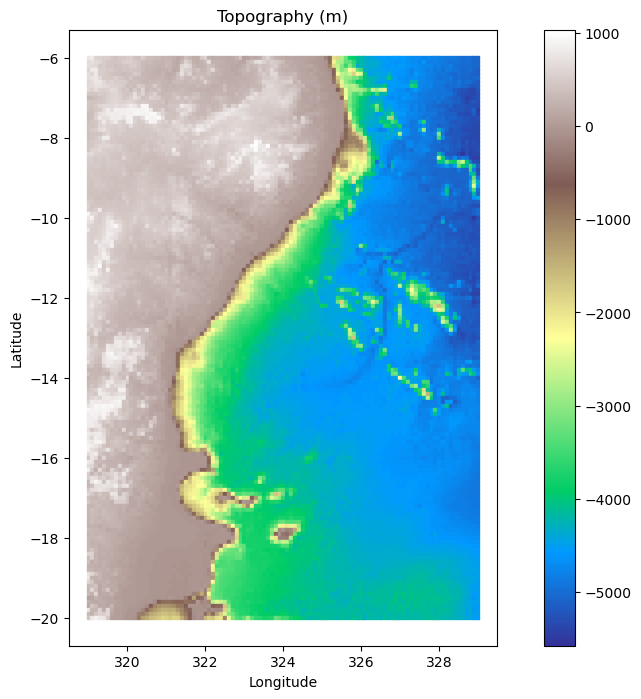

In [51]:
fig, ax = plt.subplots(figsize=(12, 8))
dados_combinados.plot(
    ax=ax,
    column='topografia', 
    cmap='terrain', 
    markersize=5, 
    marker='s',
    legend=True
)
ax.set_title('Topography (m)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

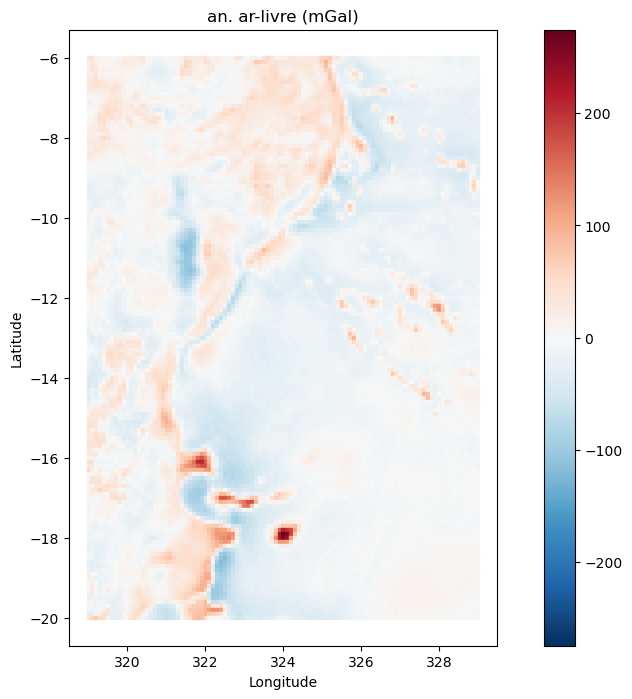

In [52]:
ranges = np.max(np.abs(dados_combinados['ar-livre']))
fig, ax = plt.subplots(figsize=(12, 8))
dados_combinados.plot(
    ax=ax,
    column='ar-livre', 
    cmap='RdBu_r', 
    markersize=5, 
    marker='s',
    legend=True,
    vmin=-ranges, vmax=ranges
)
ax.set_title('an. ar-livre (mGal)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

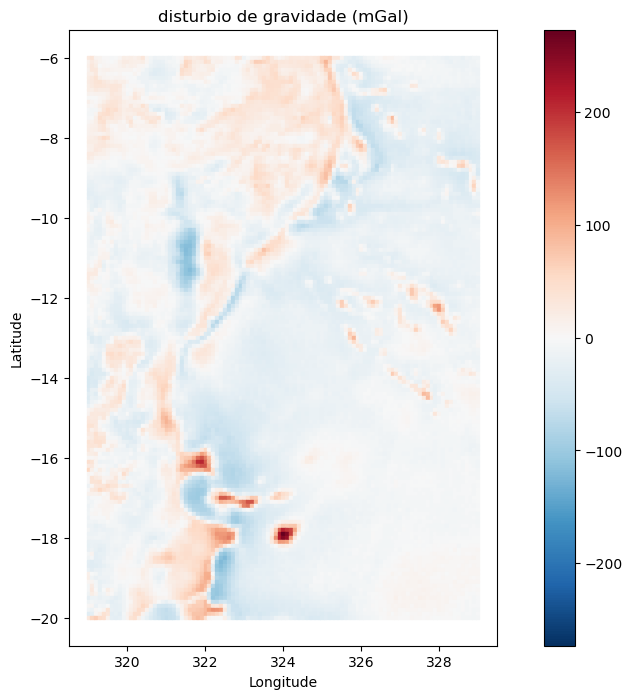

In [53]:
ranges = np.max(np.abs(dados_combinados['disturbio']))
fig, ax = plt.subplots(figsize=(12, 8))
dados_combinados.plot(
    ax=ax,
    column='disturbio', 
    cmap='RdBu_r', 
    markersize=5, 
    marker='s',
    legend=True,
    vmin=-ranges, vmax=ranges
)
ax.set_title('disturbio de gravidade (mGal)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

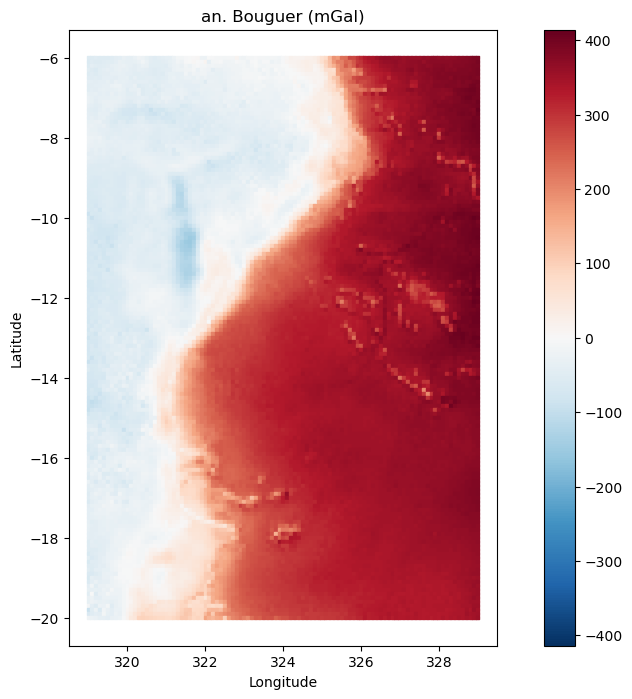

In [54]:
ranges = np.max(np.abs(dados_combinados['Bouguer']))
fig, ax = plt.subplots(figsize=(12, 8))
dados_combinados.plot(
    ax=ax,
    column='Bouguer', 
    cmap='RdBu_r', 
    markersize=5, 
    marker='s',
    legend=True,
    vmin=-ranges, vmax=ranges
)
ax.set_title('an. Bouguer (mGal)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

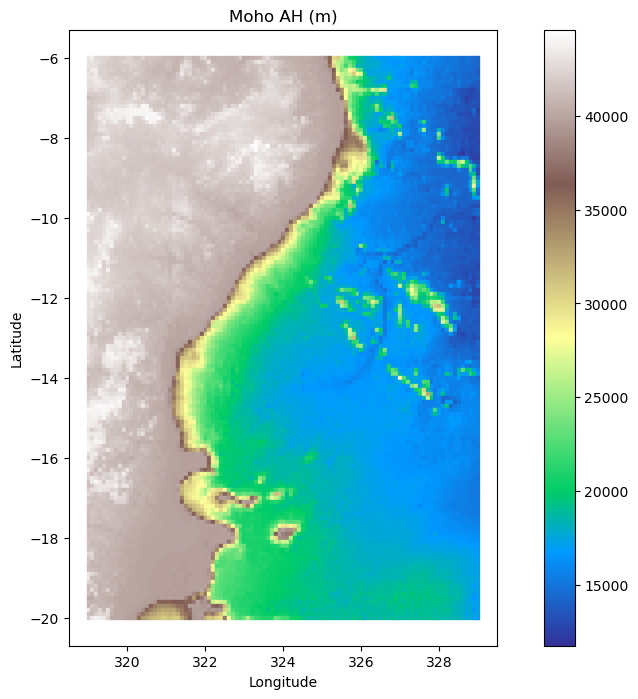

In [56]:
fig, ax = plt.subplots(figsize=(12, 8))
dados_combinados.plot(
    ax=ax,
    column='Moho-AH', 
    cmap='terrain', 
    markersize=5, 
    marker='s',
    legend=True
)
ax.set_title('Moho AH (m)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

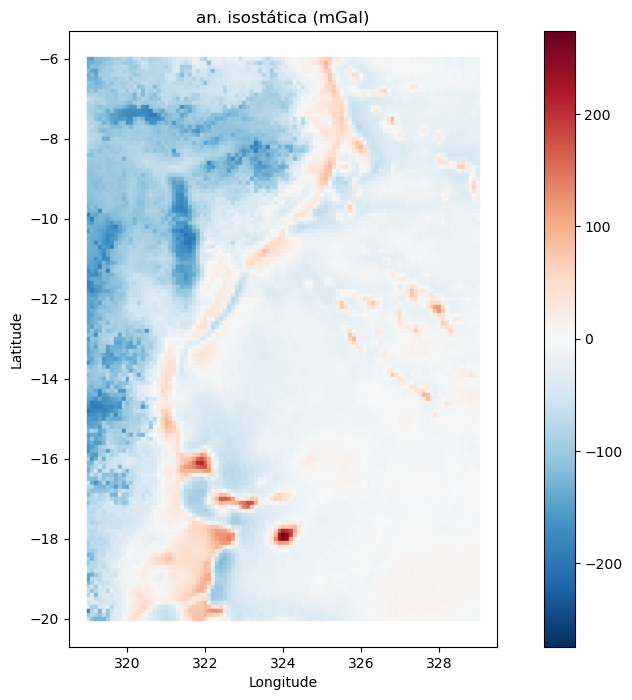

In [57]:
ranges = np.max(np.abs(dados_combinados['an-isostatica']))
fig, ax = plt.subplots(figsize=(12, 8))
dados_combinados.plot(
    ax=ax,
    column='an-isostatica', 
    cmap='RdBu_r', 
    markersize=5, 
    marker='s',
    legend=True,
    vmin=-ranges, vmax=ranges
)
ax.set_title('an. isostática (mGal)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

### Interpola dados sobre perfis

In [58]:
extremidades = [
    [(360. - 40., -14.), (360. - 36.,-14.)],
    [(360. - 38.5, -12.), (360. - 34.5, -14.)], 
    [(360. - 38., -10.), (360. - 34., -12.)], 
    [(360. - 36., -8.5), (360. - 32., -11.)]
]

In [66]:
perfis = list()

for p0, p1 in extremidades:
    perfis.append(
        profile_points_GGC(p0=p0, p1=p1, npoints=200, ellipsoid="WGS84")
    )

In [67]:
for perfil in perfis:
    for field in ['topografia', 'H', 'disturbio', 'Bouguer', 'Moho-AH', 'an-isostatica']:
        perfil[field] = griddata(
            dados_combinados[['longitude', 'latitude']].values, 
            dados_combinados[field].values,
            perfil[['longitude', 'latitude']].values, 
            method='cubic'
        )
    perfil.sort_values(by='distance', ascending=True)

In [79]:
def plot_profile(profile, nome):
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(14, 6))
    ax1, ax2 = axes
    d = profile['distance']*0.001
    ax2.fill_between(d, np.zeros_like(d), profile['topografia'], color='#2780E3')
    ax2.fill_between(d, profile['topografia'], -profile['Moho-AH'], color='#333333')
    ax2.fill_between(d, -profile['Moho-AH'], np.zeros_like(d)-45000, color='#31a354')
    ax1.hlines(0, d.min(), d.max(), linestyles='--', color='#333333')
    ax2.set_ylabel('Topografia (m)')
    ax2.set_xlabel('Distancia (km)')
    ax2.set_ylim(-45000., 5000.)

    ax1.set_title(nome, fontsize=16)
    ax1.set_ylabel('Variação de gravidade (mGal)')
    ax1.plot(d, profile['Bouguer'], '-', label='Bouguer')
    ax1.plot(d, profile['disturbio'], '-', label='Disturbio')
    ax1.plot(d, profile['an-isostatica'], '-', label='An. isostatica')
    ax1.hlines(0, d.min(), d.max(), linestyles='--', color='#333333')
    ax1.legend(loc='center right')
    ax1.set_xlim(d.min(), d.max())
    plt.tight_layout(h_pad=0, w_pad=0, pad=0)
    plt.show()

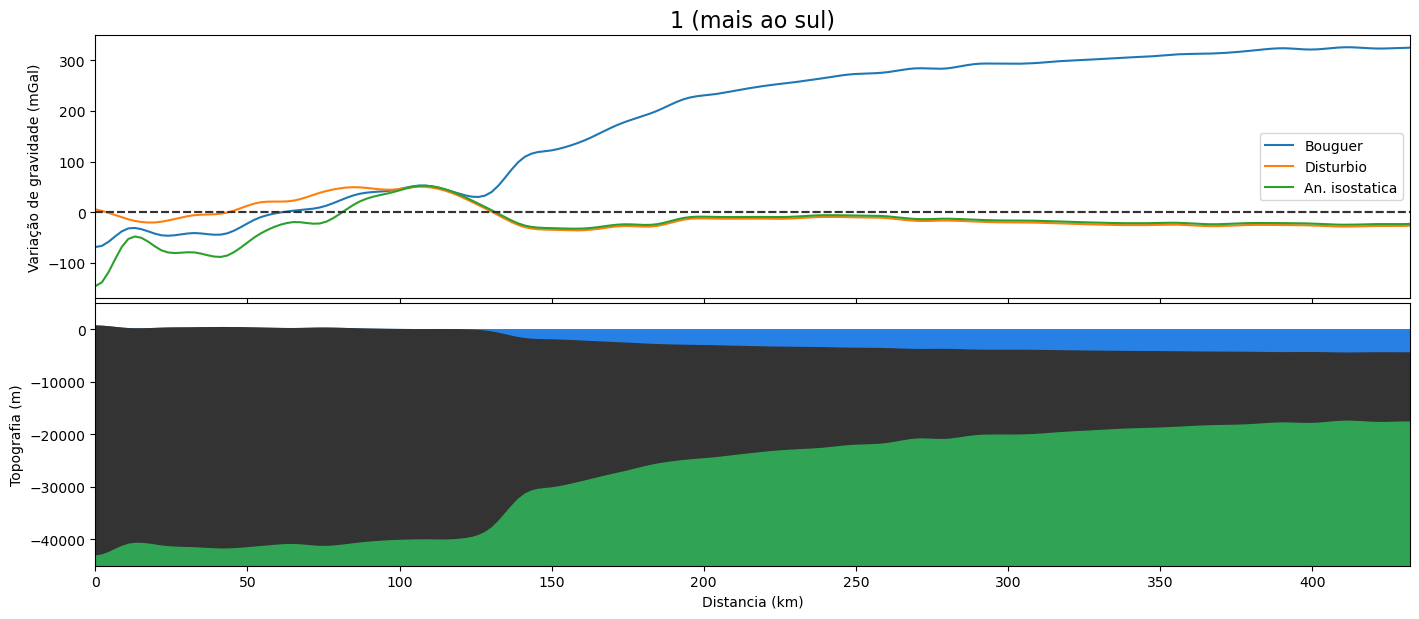

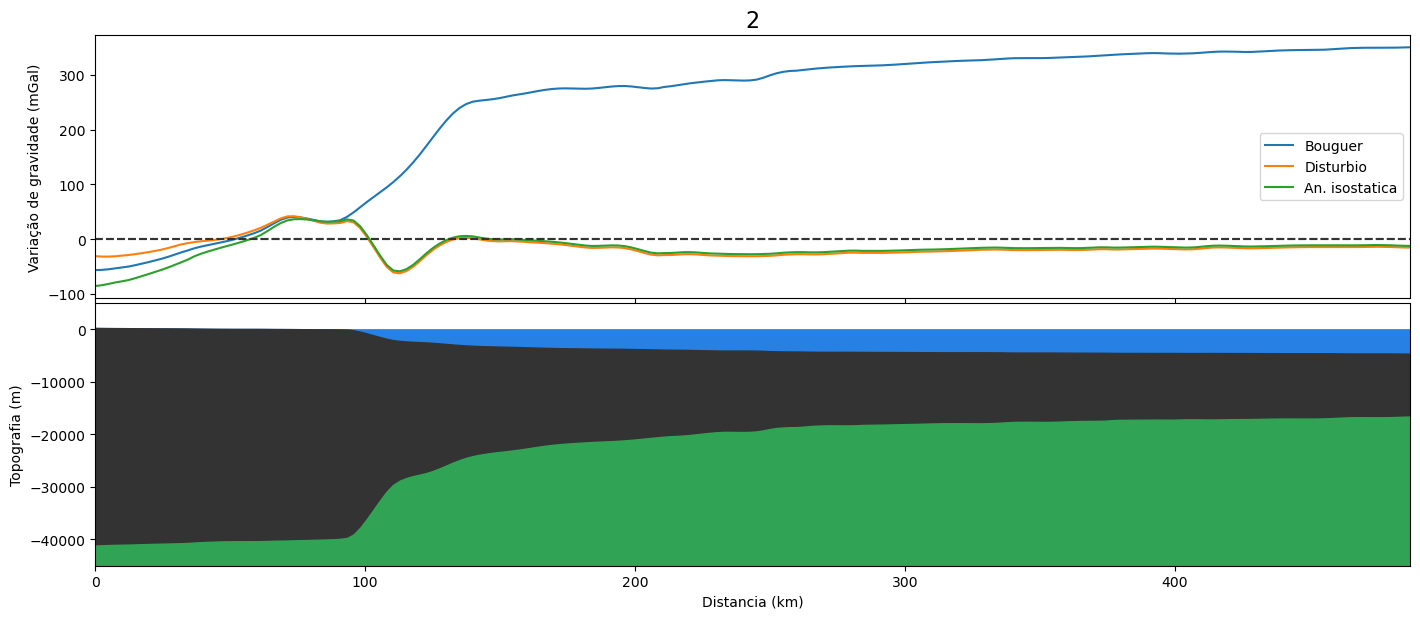

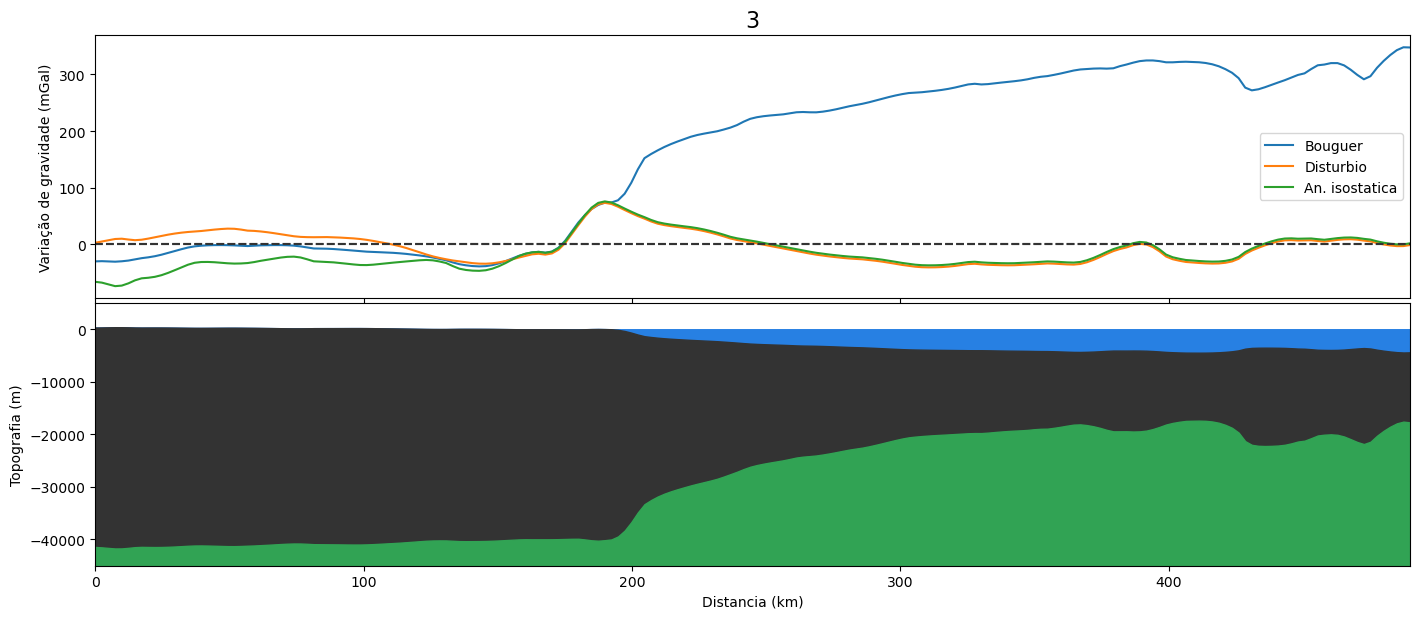

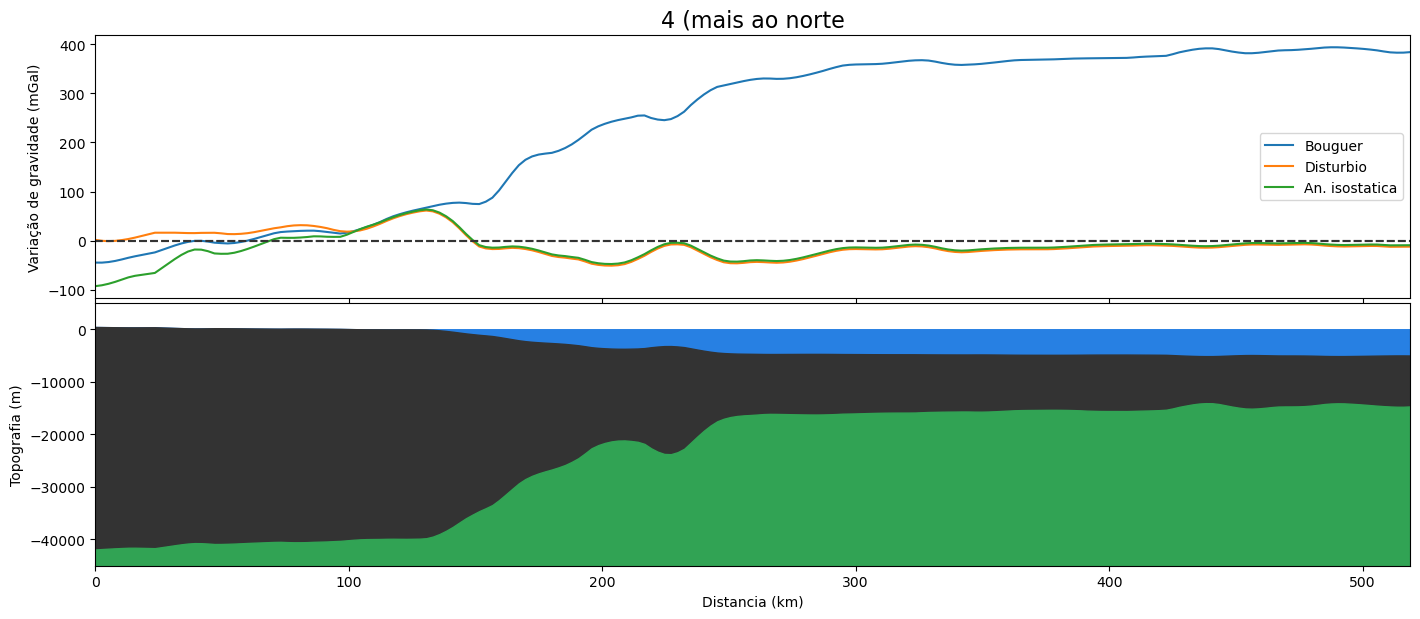

In [80]:
nomes = ['1 (mais ao sul)', '2', '3', '4 (mais ao norte']
for nome, perfil in zip(nomes, perfis):
    plot_profile(perfil, nome)

Todos os perfis mostrados acima começam no continente e terminam no oceano. Os perfis 1, 2, 3 e 4 estão dispostos, respectivamente, de sul para norte.